In [1]:
%load_ext autoreload
%autoreload 2
from Training import functions
from InputPipeline.DataLoader import CreateDataLoader
from Inference.Inference import Segmentation, Inference
from Inference.metrics import ObjectDice, ObjectHausdorff, F1score
from Inference.inference_utils import (postprocess, remove_small_object, 
                                       grow_to_fill_borders, hole_filling_per_object,
                                       split_objects)
import skimage
import torch
from matplotlib import pyplot as plt

import numpy as np
import utils

In [134]:
# ## Dataset
class Options(object):
    name = "colon_BI"
    isTrain = True
    nThreads = 0
    fineSize = 448
    device = torch.device("cuda:0")
opt = Options()
opt.dataroot = "./Datasets/ColonPair_BI/"
opt.scale_factor = 0.10
opt.alpha = 0.1
opt.batchSize = 8
opt.label_nc = 2
opt.contour = True
opt.reals = [[64, 64], [128, 128], [256, 256], [512, 512]]
opt.phase = "testB"

In [135]:
Gs, Ss, reals, NoiseAmp, NoiseAmpS = functions.load_trained_pyramid(opt)
Ss = Ss[:2]
opt.scale_num = len(Ss) - 1

In [136]:
test_dataloader = CreateDataLoader(opt, shuffle=False, fixed=True)
testset = test_dataloader.load_data()

CustomDatasetDataLoader
dataset [ContoureAwareDataset] was created


In [137]:
infer = Inference(testset, opt)

In [138]:
images, gts, predictions = infer.infer(Ss, NoiseAmpS)

Start Inference!
val_loss: 0.569, mIOU: 0.754


## Plot the image and ground truth label

In [139]:
images = ((images + 1) / 2 * 255).astype(np.uint32)
masked_images = utils.image_w_mask_overlay(images,gts[:,0,...],num_classes=2).astype(np.uint32)

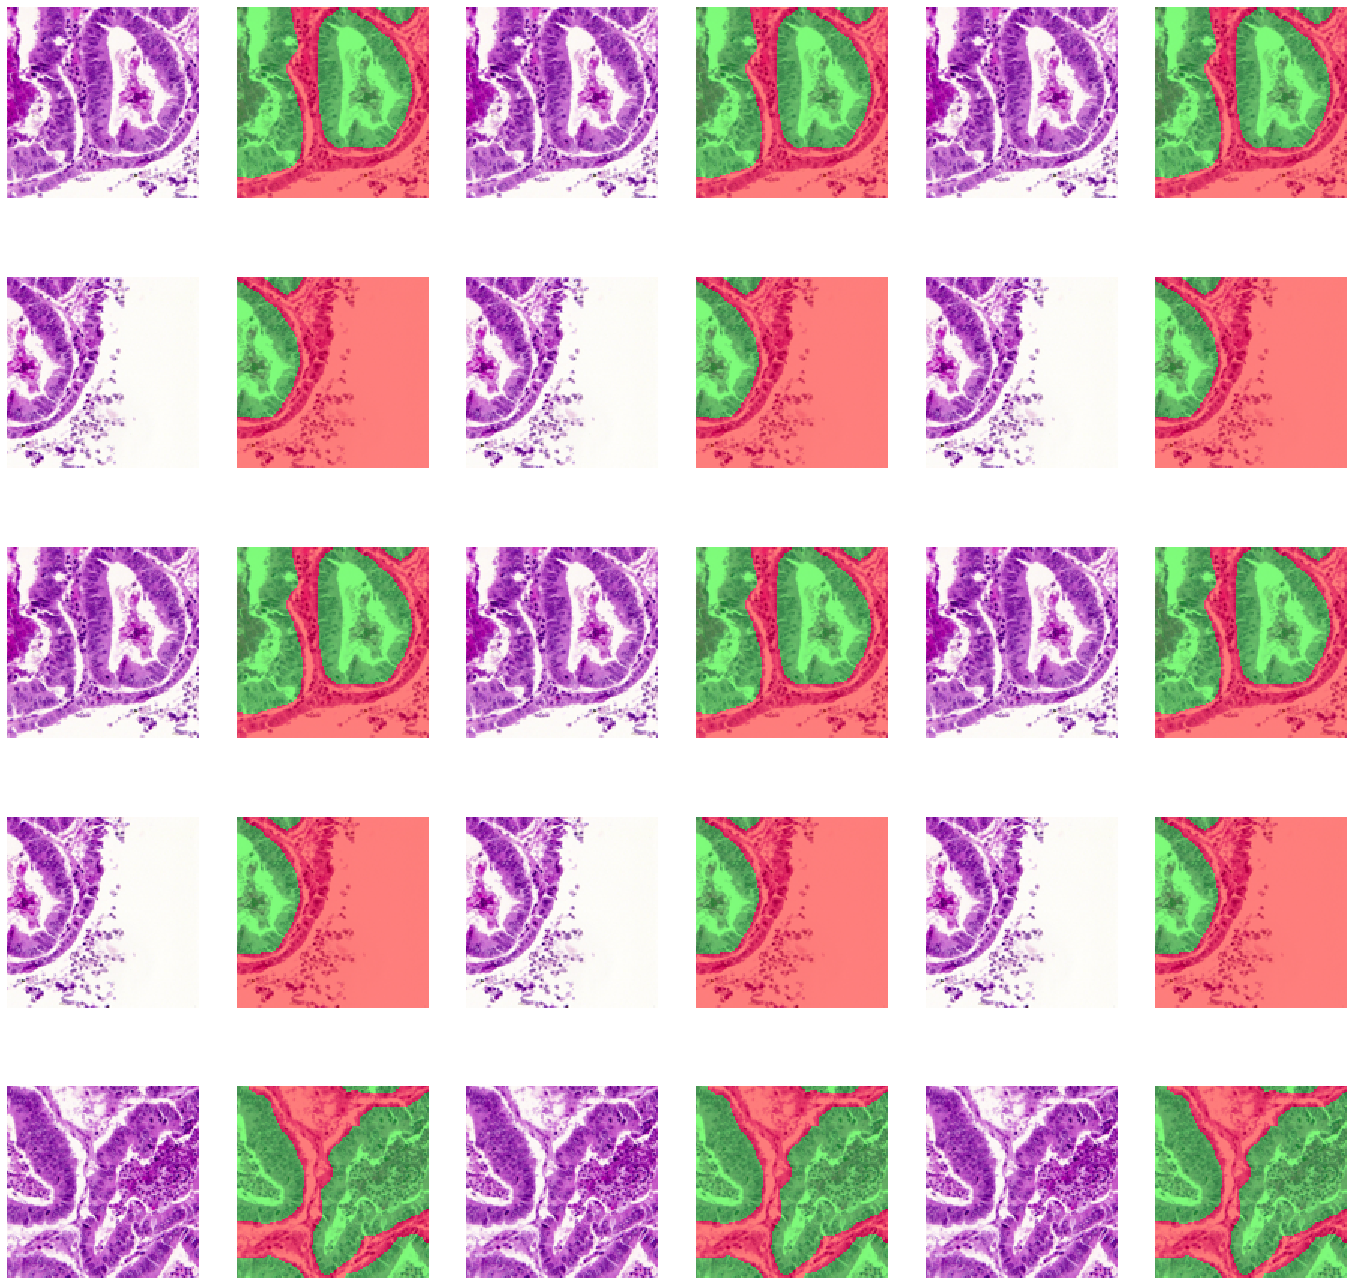

In [140]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(24, 24))
for y in range(5):
    for x in range(3):
        image = images[y]
        masked_image = masked_images[y]
        ax[y, x * 2].imshow(image.transpose(1,2,0))
        ax[y, x * 2 + 1].imshow(masked_image.transpose(1,2,0))
        ax[y, x * 2].axis('off')
        ax[y, x * 2 + 1].axis('off')

plt.show();

## Plot the image and predictions

In [141]:
preds_prob = predictions
preds = (preds_prob > 0.5).astype(np.int)
masked_preds = utils.image_w_mask_overlay(images,preds,num_classes=2).astype(np.uint32)

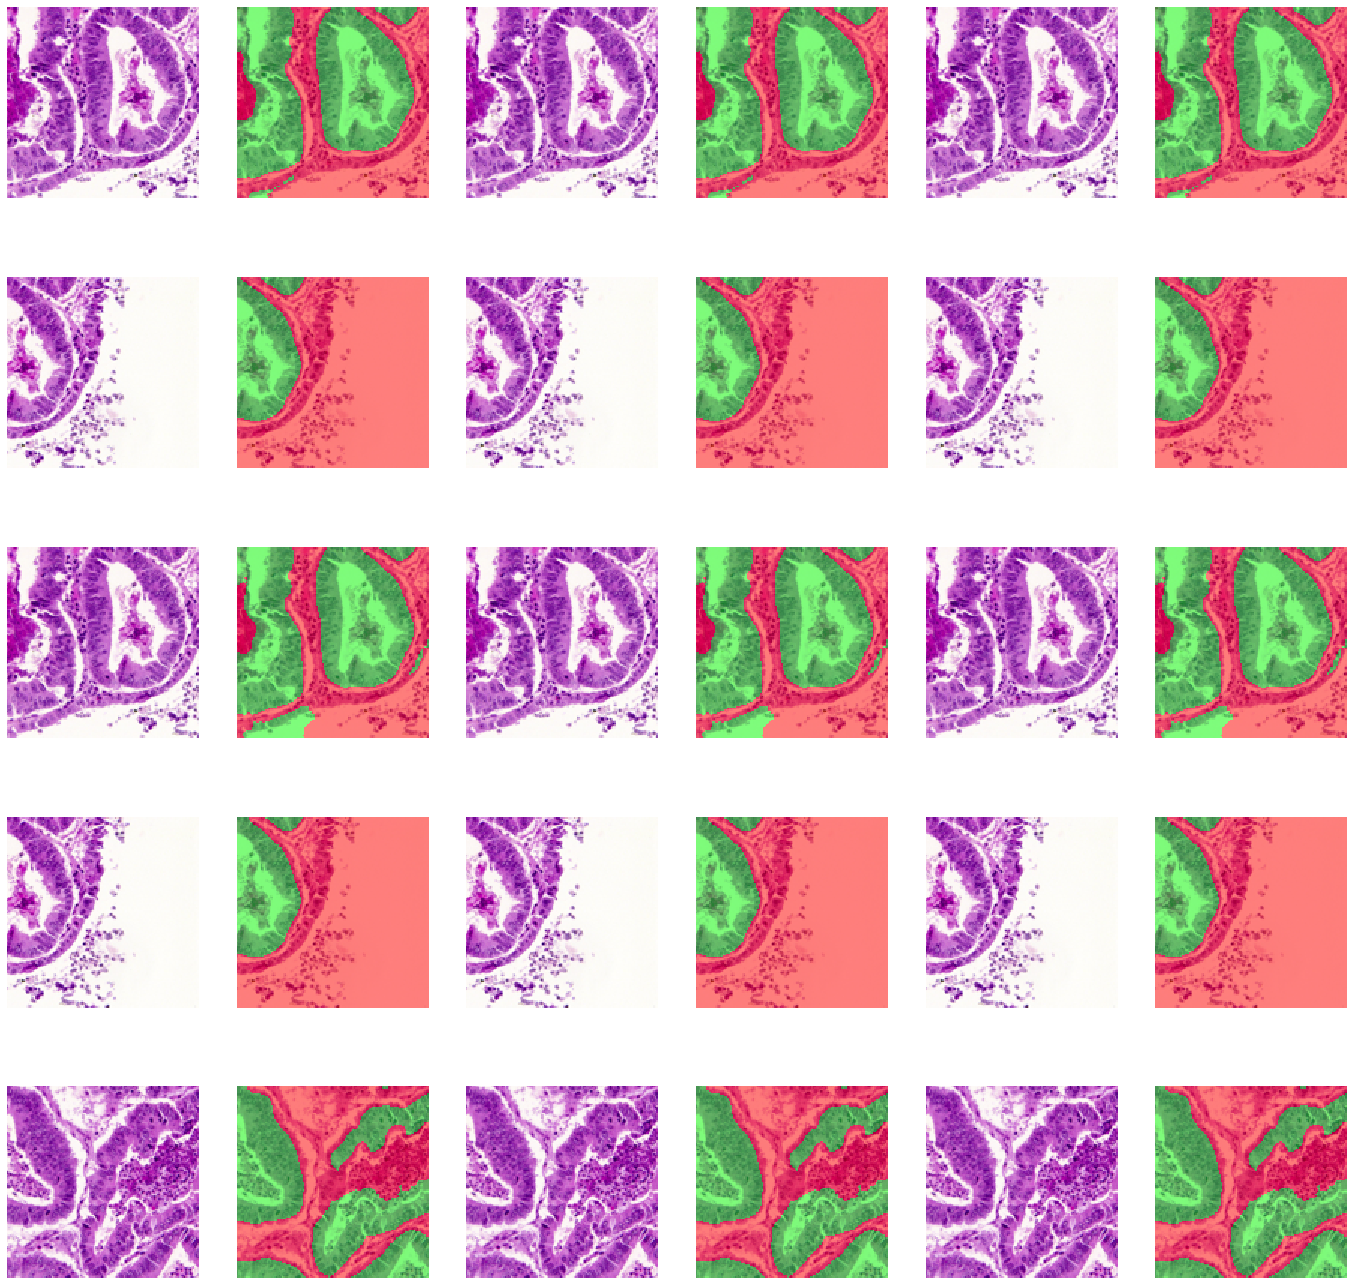

In [142]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(24, 24))
for y in range(5):
    for x in range(3):
        image = images[y]
        masked_pred = masked_preds[y]
        ax[y, x * 2].imshow(image.transpose(1,2,0))
        ax[y, x * 2 + 1].imshow(masked_pred.transpose(1,2,0))
        ax[y, x * 2].axis('off')
        ax[y, x * 2 + 1].axis('off')

plt.show();

## Instance mask

In [143]:
# def postprocess(pred_prob):
#     splitted = split_objects(pred_prob)
#     labeled = skimage.measure.label(np.asarray(splitted))
#     temp = remove_small_object(labeled, threshold=30)
#     growed = grow_to_fill_borders(temp, pred_prob[1] > 0.5)
#     hole_filled = hole_filling_per_object(growed)
#     temp = remove_small_object(hole_filled, threshold=30)
#     return temp
# #     return labeled

In [144]:
def postprocess(pred_prob):
    splitted = split_objects(pred_prob)
    labeled = skimage.measure.label(np.asarray(splitted))
    temp = remove_small_object(labeled, threshold=40)
    growed = grow_to_fill_borders(temp, pred_prob[0] > 0.5)
    hole_filled = hole_filling_per_object(growed)
    temp = remove_small_object(hole_filled, threshold=40)
    return temp
#     return labeled

In [145]:
predictions = []
ground_truth = []
for i in range(preds.shape[0]):
    result = postprocess(preds_prob[i]) ## insert post processing
    predictions.append(np.expand_dims(result, axis = 0))
    gt = skimage.measure.label(gts[i,0,...])
    ground_truth.append(np.expand_dims(gt, axis = 0))
predictions = np.concatenate(predictions, axis = 0)
ground_truth = np.concatenate(ground_truth, axis = 0)

In [146]:
preds_instance = utils.image_w_instance_overlay(images, predictions).astype(np.uint32)
gt_instance = utils.image_w_instance_overlay(images, ground_truth).astype(np.uint32)

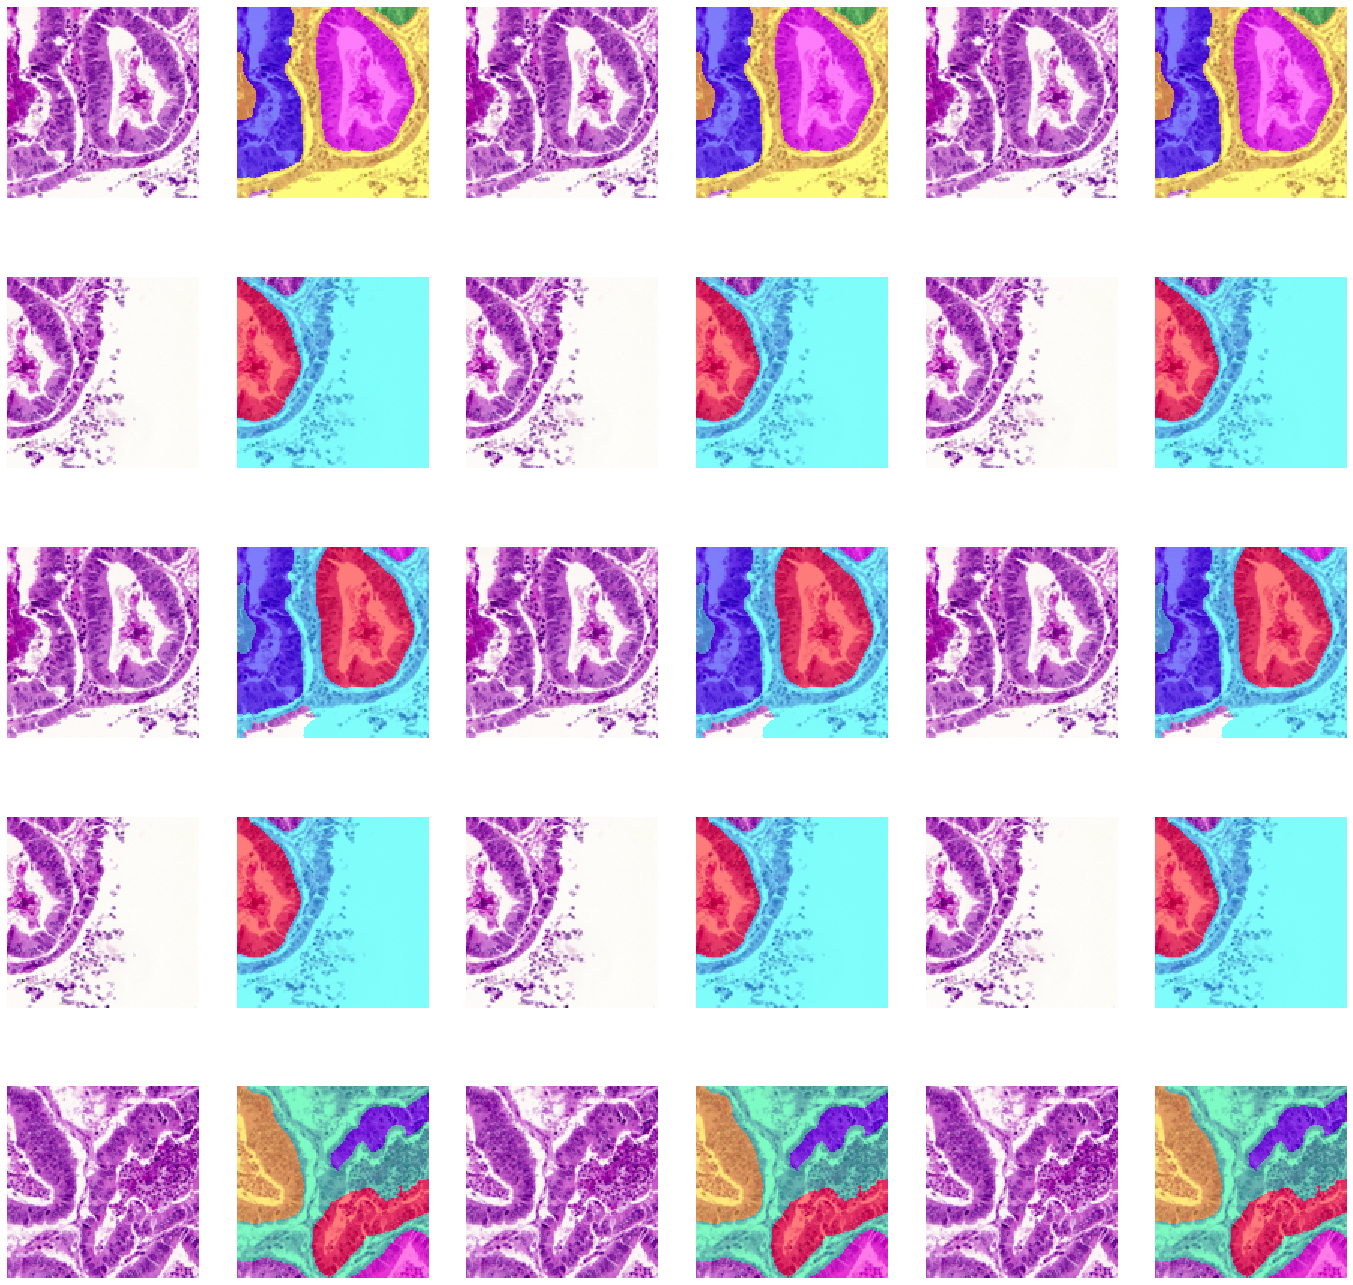

In [147]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(24, 24))
for y in range(5):
    for x in range(3):
        image = images[y]
        instance = preds_instance[y]
        ax[y, x * 2].imshow(image.transpose(1,2,0))
        ax[y, x * 2 + 1].imshow(instance.transpose(1,2,0))
        ax[y, x * 2].axis('off')
        ax[y, x * 2 + 1].axis('off')

plt.show();

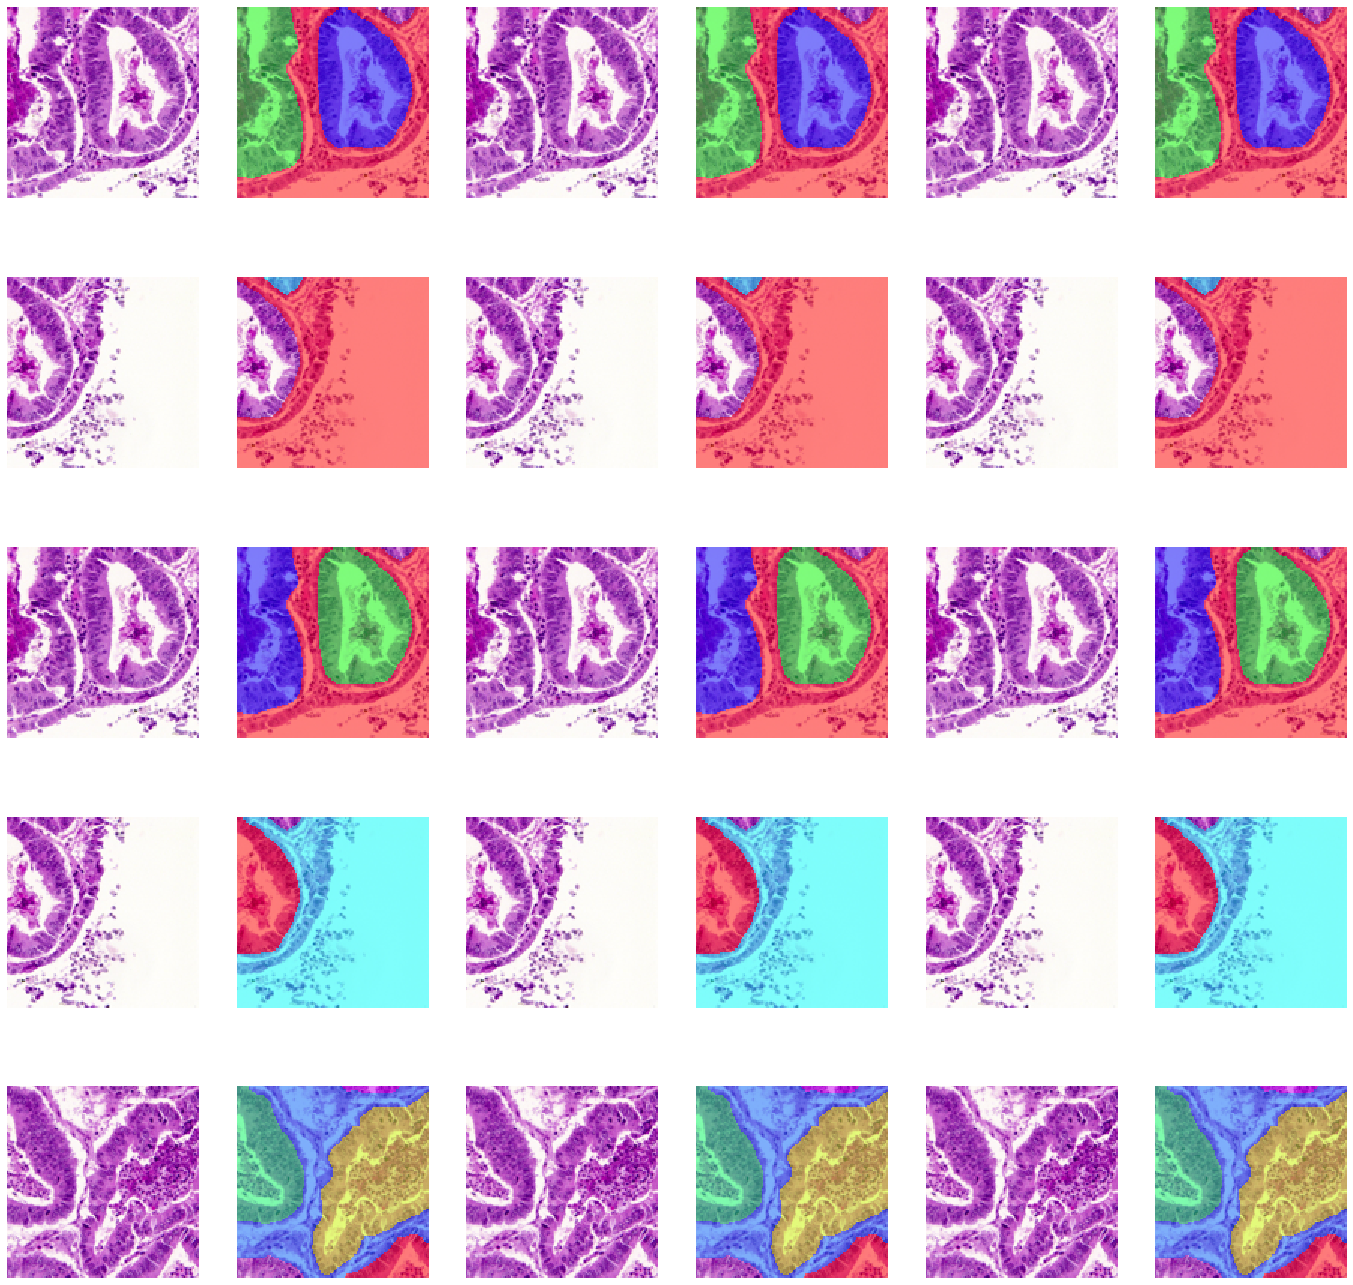

In [148]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(24, 24))
for y in range(5):
    for x in range(3):
        image = images[y]
        instance = gt_instance[y]
        ax[y, x * 2].imshow(image.transpose(1,2,0))
        ax[y, x * 2 + 1].imshow(instance.transpose(1,2,0))
        ax[y, x * 2].axis('off')
        ax[y, x * 2 + 1].axis('off')

plt.show();

## Calculate stats for evaluation

In [149]:
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
for i in range(preds.shape[0]):
    result = postprocess(preds_prob[i]) ## insert post processing
    gt = skimage.measure.label(gts[i,0,...])
    gt = np.squeeze(gt)
    
    f1_img = F1score(result, gt)
    hausdorff_img = ObjectHausdorff(result, gt)
    dice_img = ObjectDice(result, gt)
    
    f1 += f1_img
    hausdorff += hausdorff_img
    dice += dice_img

In [150]:
print('ObjectDice:', dice / preds.shape[0])
print('Hausdorff:', hausdorff / preds.shape[0])
print('F1:', f1 / preds.shape[0])

ObjectDice: 0.799210762711571
Hausdorff: 26.74650791150758
F1: 0.7160305666555664
